In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


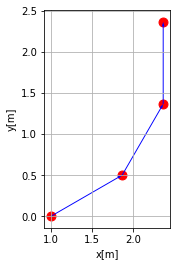

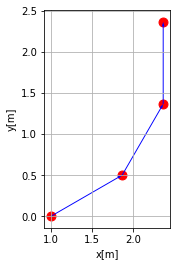

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes)

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_V_STEP = 0.3 / DATA_HZ # [m/step]
DATA_MAX_V_STEP = 0.5 / DATA_HZ # [m/step]
DATA_W_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]
DATA_MAX_W_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]
DATA_RANGE_TRANSLATE = 0 # 経路を直進方向にずらす
DATA_RANGE_ROTATE = 0 # 経路を回転方向にずらす

params = []
params.append('DATA_SIZE            :'+str(DATA_SIZE))
params.append('DATA_NUM_WAYPOINTS   :'+str(DATA_NUM_WAYPOINTS))
params.append('DATA_NUM_STEP        :'+str(DATA_NUM_STEP))
params.append('DATA_V_STEP          :'+str(DATA_V_STEP))
params.append('DATA_MAX_V_STEP      :'+str(DATA_MAX_V_STEP))
params.append('DATA_W_STEP          :'+str(DATA_W_STEP))
params.append('DATA_MAX_W_STEP      :'+str(DATA_MAX_W_STEP))
params.append('DATA_RANGE_TRANSLATE :'+str(DATA_RANGE_TRANSLATE))
params.append('DATA_RANGE_ROTATE    :'+str(DATA_RANGE_ROTATE))
for a in params:
    print(a)

DATA_SIZE            :1000
DATA_NUM_WAYPOINTS   :10
DATA_NUM_STEP        :10
DATA_V_STEP          :0.03
DATA_MAX_V_STEP      :0.05
DATA_W_STEP          :0.15707963267948966
DATA_MAX_W_STEP      :0.15707963267948966
DATA_RANGE_TRANSLATE :0
DATA_RANGE_ROTATE    :0


In [6]:
X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

1000
(10, 3)


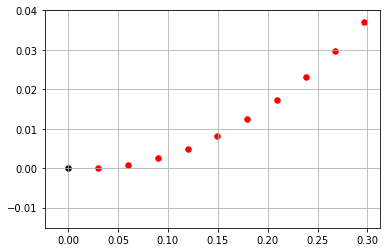

 -- x_train -- 
[[ 2.99990416e-02 -1.49485847e-07 -1.52925634e+00]
 [ 5.99865874e-02  8.30268400e-04 -1.50156634e+00]
 [ 8.99396463e-02  2.49061699e-03 -1.47387634e+00]
 [ 1.19835254e-01  4.97962331e-03 -1.44618634e+00]
 [ 1.49650489e-01  8.29537907e-03 -1.41849634e+00]
 [ 1.79362493e-01  1.24353421e-02 -1.39080634e+00]
 [ 2.08948487e-01  1.73963384e-02 -1.36311634e+00]
 [ 2.38385786e-01  2.31745644e-02 -1.33542634e+00]
 [ 2.67651823e-01  2.97655901e-02 -1.30773634e+00]
 [ 2.96724158e-01  3.71643621e-02 -1.28004634e+00]]


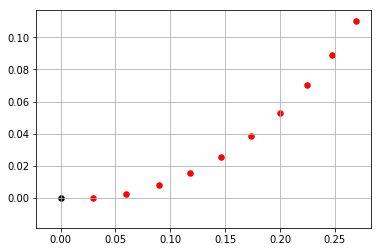

 -- x_train -- 
[[ 2.99906459e-02 -5.61205491e-08 -1.44102946e+00]
 [ 5.98691419e-02  2.59114377e-03 -1.35451946e+00]
 [ 8.94120174e-02  7.75421927e-03 -1.26800946e+00]
 [ 1.18398312e-01  1.54505541e-02 -1.18149946e+00]
 [ 1.46611228e-01  2.56225850e-02 -1.09498946e+00]
 [ 1.73839752e-01  3.81942322e-02 -1.00847946e+00]
 [ 1.99880234e-01  5.30714683e-02 -9.21969456e-01]
 [ 2.24537908e-01  7.01430218e-02 -8.35459456e-01]
 [ 2.47628353e-01  8.92812092e-02 -7.48949456e-01]
 [ 2.68978866e-01  1.10342890e-01 -6.62439456e-01]]


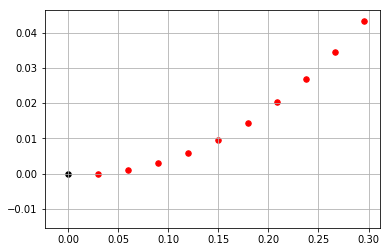

 -- x_train -- 
[[ 2.99987007e-02 -9.61181605e-08 -1.52243312e+00]
 [ 5.99818153e-02  9.66798387e-04 -1.49019312e+00]
 [ 8.99181815e-02  2.89967860e-03 -1.45795312e+00]
 [ 1.19776686e-01  5.79653561e-03 -1.42571312e+00]
 [ 1.49526295e-01  9.65435866e-03 -1.39347312e+00]
 [ 1.79136090e-01  1.44691382e-02 -1.36123312e+00]
 [ 2.08575296e-01  2.02358701e-02 -1.32899312e+00]
 [ 2.37813316e-01  2.69485608e-02 -1.29675312e+00]
 [ 2.66819763e-01  3.46002336e-02 -1.26451312e+00]
 [ 2.95564488e-01  4.31829360e-02 -1.23227312e+00]]


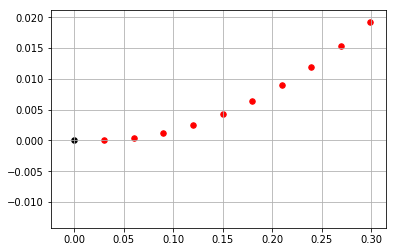

 -- x_train -- 
[[ 2.99997469e-02 -6.18493294e-08 -1.54944927e+00]
 [ 5.99964573e-02  4.26758299e-04 -1.53521927e+00]
 [ 8.99840573e-02  1.28037402e-03 -1.52098927e+00]
 [ 1.19956475e-01  2.56061246e-03 -1.50675927e+00]
 [ 1.49907640e-01  4.26721439e-03 -1.49252927e+00]
 [ 1.79831489e-01  6.39983424e-03 -1.47829927e+00]
 [ 2.09721963e-01  8.95804017e-03 -1.46406927e+00]
 [ 2.39573008e-01  1.19413142e-02 -1.44983927e+00]
 [ 2.69378580e-01  1.53490522e-02 -1.43560927e+00]
 [ 2.99132644e-01  1.91805641e-02 -1.42137927e+00]]


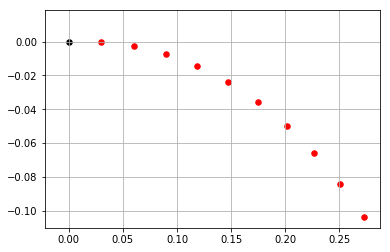

 -- x_train -- 
[[ 2.99918378e-02  3.01980344e-08 -1.69201233e+00]
 [ 5.98858042e-02 -2.42094315e-03 -1.77282233e+00]
 [ 8.94867901e-02 -7.24711906e-03 -1.85363233e+00]
 [ 1.18601599e-01 -1.44469985e-02 -1.93444233e+00]
 [ 1.47040206e-01 -2.39735901e-02 -2.01525233e+00]
 [ 1.74617002e-01 -3.57647165e-02 -2.09606233e+00]
 [ 2.01152001e-01 -4.97434205e-02 -2.17687233e+00]
 [ 2.26472017e-01 -6.58184673e-02 -2.25768233e+00]
 [ 2.50411793e-01 -8.38849399e-02 -2.33849233e+00]
 [ 2.72815083e-01 -1.03824924e-01 -2.41930233e+00]]


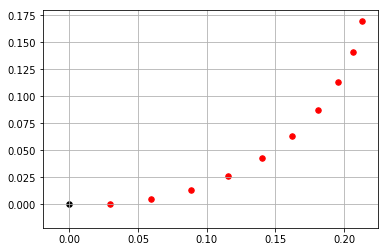

 -- x_train -- 
[[ 2.99719765e-02 -9.37386197e-08 -1.34616820e+00]
 [ 5.96085329e-02  4.47136077e-03 -1.19641820e+00]
 [ 8.82463084e-02  1.33142781e-02 -1.04666820e+00]
 [ 1.15244299e-01  2.63307257e-02 -8.96918199e-01]
 [ 1.39998202e-01  4.32293538e-02 -7.47168199e-01]
 [ 1.61953948e-01  6.36319174e-02 -5.97418199e-01]
 [ 1.80620097e-01  8.70817421e-02 -4.47668199e-01]
 [ 1.95578840e-01  1.13053946e-01 -2.97918199e-01]
 [ 2.06495354e-01  1.40967188e-01 -1.48168199e-01]
 [ 2.13125291e-01  1.70196682e-01  1.58180075e-03]]


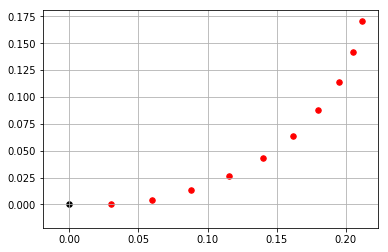

 -- x_train -- 
[[ 2.99714993e-02 -2.92286955e-08 -1.34426535e+00]
 [ 5.96018715e-02  4.50905208e-03 -1.19324535e+00]
 [ 8.82166190e-02  1.34246004e-02 -1.04222535e+00]
 [ 1.15164363e-01  2.65436647e-02 -8.91205352e-01]
 [ 1.39831673e-01  4.35676061e-02 -7.40185352e-01]
 [ 1.61657030e-01  6.41088964e-02 -5.89165352e-01]
 [ 1.80143605e-01  8.76999391e-02 -4.38145352e-01]
 [ 1.94870577e-01  1.13803714e-01 -2.87125352e-01]
 [ 2.05502704e-01  1.41826003e-01 -1.36105352e-01]
 [ 2.11797959e-01  1.71128912e-01  1.49146484e-02]]


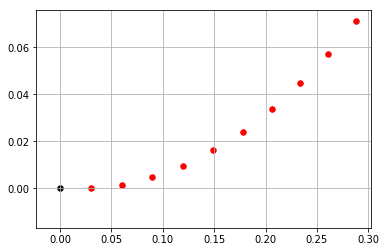

 -- x_train -- 
[[ 2.99963767e-02 -9.96312665e-08 -1.49003301e+00]
 [ 5.99492933e-02  1.61402567e-03 -1.43619301e+00]
 [ 8.97719450e-02  4.83769809e-03 -1.38235301e+00]
 [ 1.19377904e-01  9.66157529e-03 -1.32851301e+00]
 [ 1.48681372e-01  1.60716774e-02 -1.27467301e+00]
 [ 1.77597425e-01  2.40494278e-02 -1.22083301e+00]
 [ 2.06042263e-01  3.35717064e-02 -1.16699301e+00]
 [ 2.33933452e-01  4.46109174e-02 -1.11315301e+00]
 [ 2.61190162e-01  5.71350685e-02 -1.05931301e+00]
 [ 2.87733402e-01  7.11078643e-02 -1.00547301e+00]]


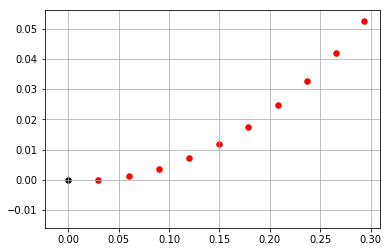

 -- x_train -- 
[[ 2.99980724e-02 -8.15702925e-08 -1.51188861e+00]
 [ 5.99730204e-02  1.17755847e-03 -1.47261861e+00]
 [ 8.98786247e-02  3.53110427e-03 -1.43334861e+00]
 [ 1.19668773e-01  7.05692683e-03 -1.39407861e+00]
 [ 1.49297530e-01  1.17495896e-02 -1.35480861e+00]
 [ 1.78719211e-01  1.76018567e-02 -1.31553861e+00]
 [ 2.07888450e-01  2.46047043e-02 -1.27626861e+00]
 [ 2.36760268e-01  3.27473346e-02 -1.23699861e+00]
 [ 2.65290149e-01  4.20171922e-02 -1.19772861e+00]
 [ 2.93434100e-01  5.23999834e-02 -1.15845861e+00]]


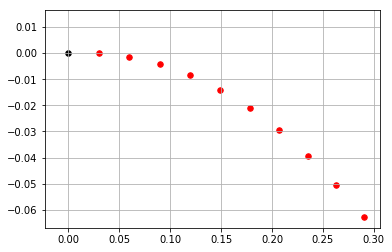

 -- x_train -- 
[[ 2.99972023e-02  9.28749909e-08 -1.64176442e+00]
 [ 5.99608448e-02 -1.41845265e-03 -1.68907442e+00]
 [ 8.98238744e-02 -4.25246212e-03 -1.73638442e+00]
 [ 1.19519463e-01 -8.49559354e-03 -1.78369442e+00]
 [ 1.48981157e-01 -1.41383516e-02 -1.83100442e+00]
 [ 1.78143027e-01 -2.11681087e-02 -1.87831442e+00]
 [ 2.06939814e-01 -2.95691336e-02 -1.92562442e+00]
 [ 2.35307075e-01 -3.93226264e-02 -1.97293442e+00]
 [ 2.63181331e-01 -5.04067605e-02 -2.02024442e+00]
 [ 2.90500203e-01 -6.27967315e-02 -2.06755442e+00]]


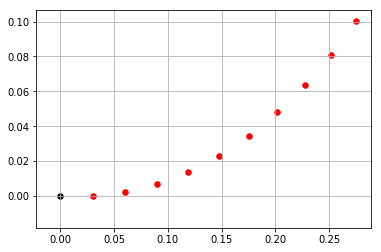

 -- x_train -- 
[[ 2.99924151e-02 -3.16469514e-08 -1.45394527e+00]
 [ 5.98938755e-02  2.33398360e-03 -1.37604527e+00]
 [ 8.95230186e-02  6.98788915e-03 -1.29814527e+00]
 [ 1.18700134e-01  1.39334575e-02 -1.22024527e+00]
 [ 1.47248251e-01  2.31285613e-02 -1.14234527e+00]
 [ 1.74994218e-01  3.45174292e-02 -1.06444527e+00]
 [ 2.01769744e-01  4.80309839e-02 -9.86545272e-01]
 [ 2.27412427e-01  6.35872608e-02 -9.08645272e-01]
 [ 2.51766736e-01  8.10919061e-02 -8.30745272e-01]
 [ 2.74684953e-01  1.00438748e-01 -7.52845272e-01]]


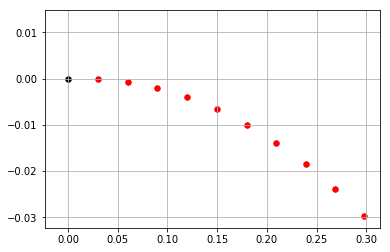

 -- x_train -- 
[[ 2.99993873e-02  6.93689677e-08 -1.60400864e+00]
 [ 5.99914239e-02 -6.63993453e-04 -1.62614864e+00]
 [ 8.99614088e-02 -1.99186297e-03 -1.64828864e+00]
 [ 1.19894652e-01 -3.98288831e-03 -1.67042864e+00]
 [ 1.49776482e-01 -6.63609356e-03 -1.69256864e+00]
 [ 1.79592251e-01 -9.95017822e-03 -1.71470864e+00]
 [ 2.09327345e-01 -1.39235179e-02 -1.73684864e+00]
 [ 2.38967188e-01 -1.85541649e-02 -1.75898864e+00]
 [ 2.68497254e-01 -2.38398496e-02 -1.78112864e+00]
 [ 2.97903067e-01 -2.97779812e-02 -1.80326864e+00]]


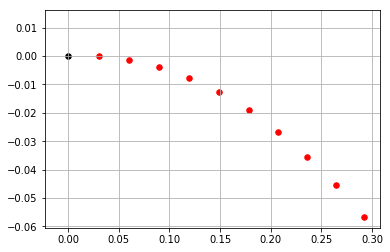

 -- x_train -- 
[[ 2.99977359e-02  1.43394422e-07 -1.63464111e+00]
 [ 5.99683137e-02 -1.27603159e-03 -1.67720111e+00]
 [ 8.98574543e-02 -3.82621369e-03 -1.71976111e+00]
 [ 1.19611026e-01 -7.64578433e-03 -1.76232111e+00]
 [ 1.49175143e-01 -1.27278260e-02 -1.80488111e+00]
 [ 1.78496262e-01 -1.90631346e-02 -1.84744111e+00]
 [ 2.07521280e-01 -2.66402365e-02 -1.89000111e+00]
 [ 2.36197631e-01 -3.54454089e-02 -1.93256111e+00]
 [ 2.64473379e-01 -4.54627049e-02 -1.97512111e+00]
 [ 2.92297315e-01 -5.66739824e-02 -2.01768111e+00]]


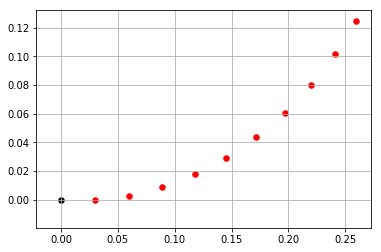

 -- x_train -- 
[[ 2.99875864e-02 -4.83333854e-08 -1.42130472e+00]
 [ 5.98263807e-02  2.98352176e-03 -1.32164472e+00]
 [ 8.92202659e-02  8.92110165e-03 -1.22198472e+00]
 [ 1.17877540e-01  1.77537674e-02 -1.12232472e+00]
 [ 1.45513811e-01  2.93938645e-02 -1.02266472e+00]
 [ 1.71854819e-01  4.37258779e-02 -9.23004715e-01]
 [ 1.96639160e-01  6.06075780e-02 -8.23344715e-01]
 [ 2.19620875e-01  7.98714327e-02 -7.23684715e-01]
 [ 2.40571897e-01  1.01326269e-01 -6.24024715e-01]
 [ 2.59284310e-01  1.24759173e-01 -5.24364715e-01]]


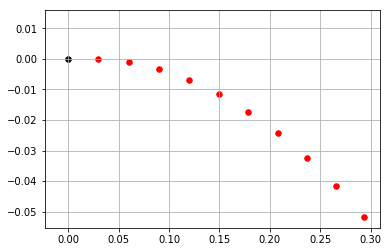

 -- x_train -- 
[[ 2.99981250e-02  1.48153430e-07 -1.62889627e+00]
 [ 5.99737598e-02 -1.16124075e-03 -1.66762627e+00]
 [ 8.98819461e-02 -3.48242483e-03 -1.70635627e+00]
 [ 1.19677827e-01 -6.95992271e-03 -1.74508627e+00]
 [ 1.49316714e-01 -1.15885188e-02 -1.78381627e+00]
 [ 1.78754153e-01 -1.73612709e-02 -1.82254627e+00]
 [ 2.07945994e-01 -2.42695210e-02 -1.86127627e+00]
 [ 2.36848454e-01 -3.23029078e-02 -1.90000627e+00]
 [ 2.65418185e-01 -4.14493828e-02 -1.93873627e+00]
 [ 2.93612336e-01 -5.16952278e-02 -1.97746627e+00]]


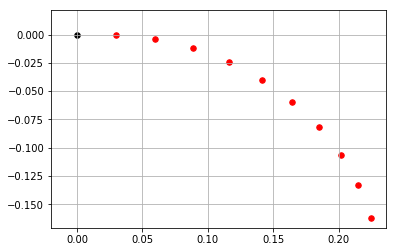

 -- x_train -- 
[[ 2.99759725e-02  5.99624640e-08 -1.77878833e+00]
 [ 5.96642468e-02 -4.14304268e-03 -1.91744833e+00]
 [ 8.84949324e-02 -1.23497777e-02 -2.05610833e+00]
 [ 1.15914601e-01 -2.44626102e-02 -2.19476833e+00]
 [ 1.41396909e-01 -4.02490245e-02 -2.33342833e+00]
 [ 1.64452705e-01 -5.94059877e-02 -2.47208833e+00]
 [ 1.84639412e-01 -8.15657662e-02 -2.61074833e+00]
 [ 2.01569531e-01 -1.06302985e-01 -2.74940833e+00]
 [ 2.14918074e-01 -1.33142794e-01 -2.88806833e+00]
 [ 2.24428805e-01 -1.61569980e-01 -3.02672833e+00]]


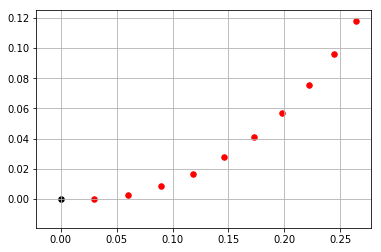

 -- x_train -- 
[[ 2.99890664e-02 -1.21893207e-07 -1.43049726e+00]
 [ 5.98470696e-02  2.80054647e-03 -1.33696726e+00]
 [ 8.93130065e-02  8.37752308e-03 -1.24343726e+00]
 [ 1.18129301e-01  1.66820569e-02 -1.14990726e+00]
 [ 1.46044055e-01  2.76415539e-02 -1.05637726e+00]
 [ 1.72813254e-01  4.11602119e-02 -9.62847262e-01]
 [ 1.98202894e-01  5.71198576e-02 -8.69317262e-01]
 [ 2.21991032e-01  7.53809801e-02 -7.75787262e-01]
 [ 2.43969724e-01  9.57839501e-02 -6.82257262e-01]
 [ 2.63946844e-01  1.18150415e-01 -5.88727262e-01]]


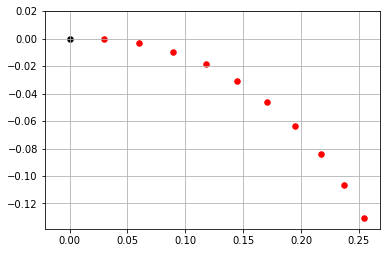

 -- x_train -- 
[[ 2.99860838e-02  9.03702002e-08 -1.72907934e+00]
 [ 5.98053925e-02 -3.15808278e-03 -1.83459934e+00]
 [ 8.91262116e-02 -9.43938747e-03 -1.94011934e+00]
 [ 1.17622372e-01 -1.87739496e-02 -2.04563934e+00]
 [ 1.44976879e-01 -3.10579301e-02 -2.15115934e+00]
 [ 1.70885437e-01 -4.61546803e-02 -2.25667934e+00]
 [ 1.95059835e-01 -6.38962617e-02 -2.36219934e+00]
 [ 2.17231153e-01 -8.40853145e-02 -2.46771934e+00]
 [ 2.37152756e-01 -1.06497253e-01 -2.57323934e+00]
 [ 2.54603032e-01 -1.30882763e-01 -2.67875934e+00]]


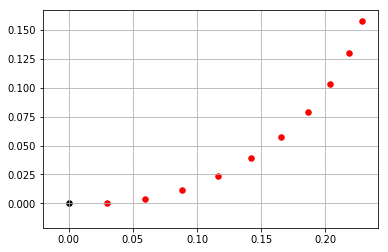

 -- x_train -- 
[[ 2.99774595e-02 -1.27654573e-07 -1.36934207e+00]
 [ 5.96849981e-02  4.01362715e-03 -1.23504207e+00]
 [ 8.85876009e-02  1.19689791e-02 -1.10074207e+00]
 [ 1.16164750e-01  2.37226572e-02 -9.66442068e-01]
 [ 1.41919796e-01  3.90629846e-02 -8.32142068e-01]
 [ 1.65388908e-01  5.77136915e-02 -6.97842068e-01]
 [ 1.86149421e-01  7.93388897e-02 -5.63542068e-01]
 [ 2.03827449e-01  1.03549123e-01 -4.29242068e-01]
 [ 2.18104624e-01  1.29908378e-01 -2.94942068e-01]
 [ 2.28723821e-01  1.57941943e-01 -1.60642068e-01]]


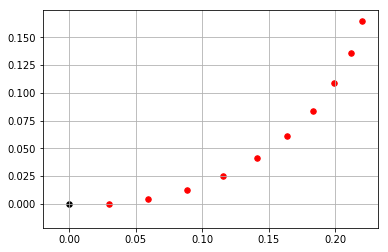

 -- x_train -- 
[[ 2.99744881e-02 -1.18090476e-07 -1.35647239e+00]
 [ 5.96435532e-02  4.26796290e-03 -1.21359239e+00]
 [ 8.84025401e-02  1.27172595e-02 -1.07071239e+00]
 [ 1.15665341e-01  2.51755752e-02 -9.27832387e-01]
 [ 1.40876340e-01  4.13890097e-02 -7.84952387e-01]
 [ 1.63521738e-01  6.10271333e-02 -6.42072387e-01]
 [ 1.83140021e-01  8.36897213e-02 -4.99192387e-01]
 [ 1.99331370e-01  1.08914911e-01 -3.56312387e-01]
 [ 2.11765804e-01  1.36188612e-01 -2.13432387e-01]
 [ 2.20189911e-01  1.64954988e-01 -7.05523871e-02]]


In [7]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    #plt.xlim([-.2,.2])
    #plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [8]:
# loss
def error_squares(z_oplus,z_true):
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance - stage cost
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS-1):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    # distance - terminal cost
    e_distance = e_distance + 10 * error_squares(z_oplus[-1],z_true[-1])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = e_diff_v + error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_diff_v) + '\t'
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = e_diff_w + error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_diff_w) + '\t'
    '''    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [9]:
# training
def train(model,opt,X,epoch=10,clipping=0):
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            # forward
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y_v, y_w = model(x)
            # clip
            if clipping:
                v_limit = DATA_MAX_V_STEP
                w_limit = DATA_MAX_W_STEP
                v = F.clip(y_v,0.0,v_limit)
                w = F.clip(y_w,-w_limit,w_limit)
            else:
                v = y_v
                w = y_w
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
            y_pad = F.stack((v,pad,w),axis=2)
            
            # loss
            loss = loss_function(y_pad, X[itr][:])
            
            # update
            model.cleargrads()
            loss.backward()
            opt.update()
            #y_grad = chainer.grad( (e,), (y,) )[0]
            #print(y_grad)
            #x_grad = chainer.grad( (e,), (x,) )[0]
            #print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    fig = plt.figure()
    plt.plot(range(len(AvgLoss)),AvgLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(AvgLoss)-1, AvgLoss[-1],str(AvgLoss[-1]),ha='center',va='top' )
    return model, fig

Epoch: 1 , Average loss: 0.64872736
Epoch: 2 , Average loss: 0.25918046
Epoch: 3 , Average loss: 0.19484383
Epoch: 4 , Average loss: 0.17140725
Epoch: 5 , Average loss: 0.15959673
Epoch: 6 , Average loss: 0.13991378
Epoch: 7 , Average loss: 0.13625489
Epoch: 8 , Average loss: 0.12772314
Epoch: 9 , Average loss: 0.116869785
Epoch: 10 , Average loss: 0.10133549
Epoch: 1 , Average loss: 0.1452819
Epoch: 2 , Average loss: 0.1084409
Epoch: 3 , Average loss: 0.09727623
Epoch: 4 , Average loss: 0.102811076
Epoch: 5 , Average loss: 0.09752561
Epoch: 6 , Average loss: 0.09201635
Epoch: 7 , Average loss: 0.0766669
Epoch: 8 , Average loss: 0.0683614
Epoch: 9 , Average loss: 0.06999503
Epoch: 10 , Average loss: 0.076443985
start: 2019/11/04 16:14:50
finish: 2019/11/04 16:24:03


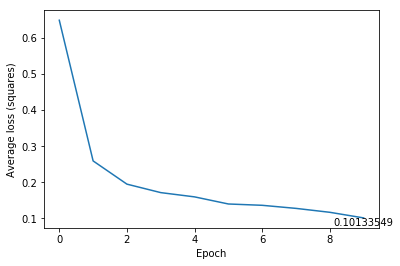

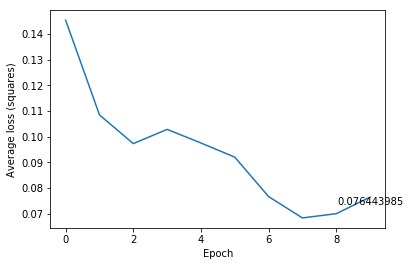

In [10]:
EPOCH = 10
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
if settings.gpu_index >= 0:
    cuda.cupy.cuda.Device(settings.gpu_index).use()
    model.to_gpu(settings.gpu_index)
opt = optimizers.Adam()
opt.setup(model)
model,fig = train(model,opt,X_train,epoch=EPOCH)
model,fig = train(model,opt,X_train,epoch=EPOCH,clipping=1)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

In [11]:
# log
def gen_filename():
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_V_STEP * 1000))
    fn = 'Model' + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename()
print(dirname)

Model30mm10step_201911041624_1000data10ep


In [12]:
os.mkdir(dirname)
f = open(dirname+'/params.txt','w')
for l in params:
    f.write(l+'\n')
f.close()
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 2.99722304e-02 -1.00347215e-07 -1.34718798e+00]
 [ 5.96120725e-02  4.45123144e-03 -1.19811798e+00]
 [ 8.82620925e-02  1.32552615e-02 -1.04904798e+00]
 [ 1.15286812e-01  2.62167099e-02 -8.99977979e-01]
 [ 1.40086802e-01  4.30480821e-02 -7.50907979e-01]
 [ 1.62111980e-01  6.33760457e-02 -6.01837979e-01]
 [ 1.80873813e-01  8.67497113e-02 -4.52767979e-01]
 [ 1.95956147e-01  1.12650634e-01 -3.03697979e-01]
 [ 2.07024447e-01  1.40504311e-01 -1.54627979e-01]
 [ 2.13833208e-01  1.69692928e-01 -5.55797879e-03]]
 --- output --- 
[[[ 0.02871808  0.          0.14138757]
  [ 0.02928981  0.          0.1564442 ]
  [ 0.02908904  0.          0.15217805]
  [ 0.03384473  0.          0.15323529]
  [ 0.024286    0.          0.15566176]
  [ 0.03067273  0.          0.15707964]
  [ 0.03023706  0.          0.15707964]
  [ 0.02934286  0.          0.15707964]
  [ 0.03067408  0.         -0.15707964]
  [ 0.02781458  0.         -0.15707964]]]
 --- error --- 
e_distance: variable(0.0747477)	
loss:

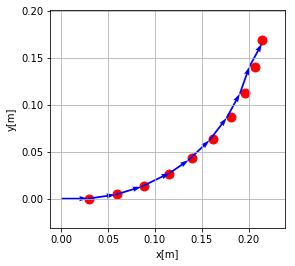

 --- grad --- 
variable([[-6.4327054 -6.836086  -7.2371187 -7.4582376 -9.42305
           -9.392234  -9.321144  -9.330439  -9.366897  -8.3419   ]])
variable([[-1.6003857  -1.3228694  -1.0778702  -0.82528937 -0.6639128
            0.          0.          0.          0.          0.        ]])


In [13]:
rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
d = data.rotate_path(d,rand_rad*0.5)
if DATA_RANGE_TRANSLATE != 0:
    rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
    d = data.translate_path(d,rand_trans_x,0.0)
if DATA_RANGE_ROTATE != 0:
    rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
    d = data.rotate_path(d,rand_rotate)
x_test = d
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
x = xp.ravel(x_test[:,0:2])
x = xp.array([x],dtype=xp.float32)
y_v,y_w = model(x)
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
# loss
print(' --- error --- ')
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
print(' --- grad --- ')
v_grad = chainer.grad( (loss,), (y_v,) )[0]
print(v_grad)
w_grad = chainer.grad( (loss,), (y_w,) )[0]
print(w_grad)
#x_grad = chainer.grad( (loss,), (x,) )[0]
#print(x_grad)

 --- input --- 
[[ 2.99987439e-02 -1.91407751e-08 -1.52324569e+00]
 [ 5.99824170e-02  9.50762649e-04 -1.49154569e+00]
 [ 8.99208914e-02  2.85139002e-03 -1.45984569e+00]
 [ 1.19784085e-01  5.69995321e-03 -1.42814569e+00]
 [ 1.49541991e-01  9.49358996e-03 -1.39644569e+00]
 [ 1.79164708e-01  1.42284884e-02 -1.36474569e+00]
 [ 2.08622471e-01  1.98998909e-02 -1.33304569e+00]
 [ 2.37885682e-01  2.65020988e-02 -1.30134569e+00]
 [ 2.66924935e-01  3.40284781e-02 -1.26964569e+00]
 [ 2.95711053e-01  4.24714663e-02 -1.23794569e+00]]
 --- output --- 
[[[ 0.02702178  0.          0.02532756]
  [ 0.02444956  0.          0.04070615]
  [ 0.03646912  0.          0.03046543]
  [ 0.02845715  0.          0.0269828 ]
  [ 0.02766885  0.          0.01576175]
  [ 0.03406584  0.          0.03926822]
  [ 0.03564895  0.          0.08983971]
  [ 0.02392077  0.          0.06295177]
  [ 0.0315231   0.         -0.15707964]
  [ 0.03029031  0.         -0.15707964]]]
 --- error --- 
loss: variable(0.00297696)
loss: varia

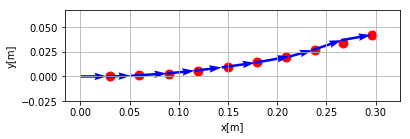

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99912750e-02  1.13162074e-08 -1.69612170e+00]
 [ 5.98779333e-02 -2.50283415e-03 -1.77967170e+00]
 [ 8.94514692e-02 -7.49107520e-03 -1.86322170e+00]
 [ 1.18505562e-01 -1.49299111e-02 -1.94677170e+00]
 [ 1.46837514e-01 -2.47674446e-02 -2.03032170e+00]
 [ 1.74249667e-01 -3.69350437e-02 -2.11387170e+00]
 [ 2.00550778e-01 -5.13478206e-02 -2.19742170e+00]
 [ 2.25557356e-01 -6.79052239e-02 -2.28097170e+00]
 [ 2.49094943e-01 -8.64917402e-02 -2.36452170e+00]
 [ 2.70999327e-01 -1.06977700e-01 -2.44807170e+00]]
 --- output --- 
[[[ 0.0304727   0.         -0.07349686]
  [ 0.02855557  0.         -0.09046004]
  [ 0.02879337  0.         -0.08841881]
  [ 0.03157244  0.         -0.09063113]
  [ 0.02916243  0.         -0.09296094]
  [ 0.0304981   0.         -0.08214198]
  [ 0.03019062  0.         -0.05543069]
  [ 0.03036661  0.         -0.06757045]
  [ 0.0285897   0.         -0.15707964]

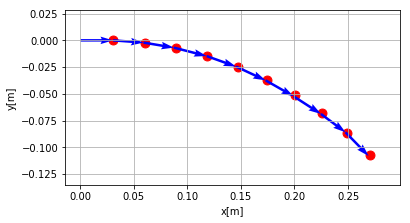

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99999980e-02  4.02933361e-08 -1.57268767e+00]
 [ 5.99999723e-02 -3.77194009e-05 -1.57394767e+00]
 [ 8.99998751e-02 -1.13279023e-04 -1.57520767e+00]
 [ 1.19999659e-01 -2.26638452e-04 -1.57646767e+00]
 [ 1.49999276e-01 -3.77797509e-04 -1.57772767e+00]
 [ 1.79998679e-01 -5.66755954e-04 -1.57898767e+00]
 [ 2.09997820e-01 -7.93513486e-04 -1.58024767e+00]
 [ 2.39996652e-01 -1.05806975e-03 -1.58150767e+00]
 [ 2.69995126e-01 -1.36042431e-03 -1.58276767e+00]
 [ 2.99993195e-01 -1.70057671e-03 -1.58402767e+00]]
 --- output --- 
[[[ 0.02848037  0.         -0.00151367]
  [ 0.02618389  0.          0.00365935]
  [ 0.03493476  0.         -0.00215673]
  [ 0.02734119  0.         -0.00576993]
  [ 0.02941588  0.         -0.01499631]
  [ 0.03241707  0.          0.00705005]
  [ 0.03388817  0.          0.05142219]
  [ 0.02665985  0.          0.02518144]
  [ 0.03081207  0.         -0.15707964]

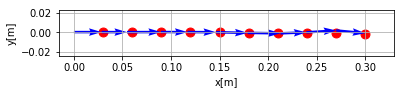

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99999180e-02  1.01983100e-07 -1.58294973e+00]
 [ 5.99988527e-02 -2.42792716e-04 -1.59104973e+00]
 [ 8.99948358e-02 -7.28668160e-04 -1.59914973e+00]
 [ 1.19985899e-01 -1.45749247e-03 -1.60724973e+00]
 [ 1.49970076e-01 -2.42921783e-03 -1.61534973e+00]
 [ 1.79945397e-01 -3.64378049e-03 -1.62344973e+00]
 [ 2.09909898e-01 -5.10110075e-03 -1.63154973e+00]
 [ 2.39861612e-01 -6.80108301e-03 -1.63964973e+00]
 [ 2.69798573e-01 -8.74361573e-03 -1.64774973e+00]
 [ 2.99718818e-01 -1.09285715e-02 -1.65584973e+00]]
 --- output --- 
[[[ 2.8824389e-02  0.0000000e+00 -7.1565052e-03]
  [ 2.6538096e-02  0.0000000e+00 -4.2936872e-03]
  [ 3.4475006e-02  0.0000000e+00 -9.1859503e-03]
  [ 2.7299935e-02  0.0000000e+00 -1.2713239e-02]
  [ 2.9680790e-02  0.0000000e+00 -2.1379458e-02]
  [ 3.2035708e-02  0.0000000e+00  2.0135194e-05]
  [ 3.3480678e-02  0.0000000e+00  4.3137696e-02]
  [ 2.7212065e-0

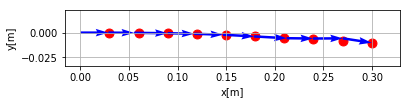

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99979629e-02 -1.99805264e-08 -1.51024066e+00]
 [ 5.99714855e-02  1.21064890e-03 -1.46987066e+00]
 [ 8.98717255e-02  3.63003385e-03 -1.42950066e+00]
 [ 1.19649960e-01  7.25419243e-03 -1.38913066e+00]
 [ 1.49257665e-01  1.20772190e-02 -1.34876066e+00]
 [ 1.78646594e-01  1.80912544e-02 -1.30839066e+00]
 [ 2.07768858e-01  2.52864987e-02 -1.26802066e+00]
 [ 2.36577001e-01  3.36512270e-02 -1.22765066e+00]
 [ 2.65024079e-01  4.31718090e-02 -1.18728066e+00]
 [ 2.93063739e-01  5.38327307e-02 -1.14691066e+00]]
 --- output --- 
[[[ 0.02819481  0.          0.03603168]
  [ 0.02448554  0.          0.04889616]
  [ 0.03502698  0.          0.03915664]
  [ 0.02936849  0.          0.03619897]
  [ 0.02753224  0.          0.02647334]
  [ 0.03343309  0.          0.04768814]
  [ 0.03494438  0.          0.10231053]
  [ 0.02436096  0.          0.07198709]
  [ 0.03098259  0.         -0.15707964]

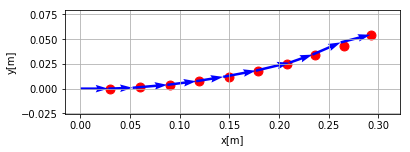

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99742053e-02  5.40405986e-08 -1.78630313e+00]
 [ 5.96396003e-02 -4.29148707e-03 -1.92997313e+00]
 [ 8.83849120e-02 -1.27861936e-02 -2.07364313e+00]
 [ 1.15617826e-01 -2.53090271e-02 -2.21731313e+00]
 [ 1.40777193e-01 -4.16019473e-02 -2.36098313e+00]
 [ 1.63344589e-01 -6.13292289e-02 -2.50465313e+00]
 [ 1.82854999e-01 -8.40843796e-02 -2.64832313e+00]
 [ 1.98906400e-01 -1.09398516e-01 -2.79199313e+00]
 [ 2.11168043e-01 -1.36750026e-01 -2.93566313e+00]
 [ 2.19387270e-01 -1.65575315e-01 -3.07933313e+00]]
 --- output --- 
[[[ 0.02794031  0.         -0.1261104 ]
  [ 0.02606081  0.         -0.1476283 ]
  [ 0.02395445  0.         -0.14601335]
  [ 0.04210492  0.         -0.14922653]
  [ 0.02373561  0.         -0.1474723 ]
  [ 0.03562233  0.         -0.147068  ]
  [ 0.03003124  0.         -0.13497543]
  [ 0.02755311  0.         -0.12197562]
  [ 0.02649376  0.         -0.15707964]

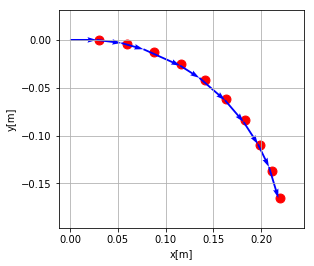

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99999847e-02 -1.44553733e-07 -1.56554151e+00]
 [ 5.99997861e-02  1.04710625e-04 -1.56204151e+00]
 [ 8.99990368e-02  3.14564253e-04 -1.55854151e+00]
 [ 1.19997369e-01  6.29413758e-04 -1.55504151e+00]
 [ 1.49994416e-01  1.04925528e-03 -1.55154151e+00]
 [ 1.79989810e-01  1.57408369e-03 -1.54804151e+00]
 [ 2.09983183e-01  2.20389254e-03 -1.54454151e+00]
 [ 2.39974168e-01  2.93867413e-03 -1.54104151e+00]
 [ 2.69962397e-01  3.77841945e-03 -1.53754151e+00]
 [ 2.99947504e-01  4.72311821e-03 -1.53404151e+00]]
 --- output --- 
[[[ 0.02822814  0.          0.0023546 ]
  [ 0.02592788  0.          0.00916474]
  [ 0.03524736  0.          0.0026845 ]
  [ 0.02740595  0.         -0.0009734 ]
  [ 0.02920487  0.         -0.01058397]
  [ 0.03269181  0.          0.01187281]
  [ 0.03417832  0.          0.05709261]
  [ 0.026256    0.          0.03072876]
  [ 0.03093919  0.         -0.15707964]

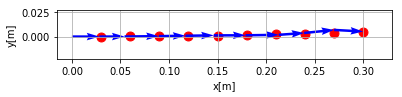

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99891829e-02 -7.88684284e-08 -1.43124870e+00]
 [ 5.98486949e-02  2.78571381e-03 -1.33821870e+00]
 [ 8.93203006e-02  8.33328554e-03 -1.24518870e+00]
 [ 1.18149119e-01  1.65946590e-02 -1.15215870e+00]
 [ 1.46085830e-01  2.74983871e-02 -1.05912870e+00]
 [ 1.72888827e-01  4.09501707e-02 -9.66098697e-01]
 [ 1.98326307e-01  5.68336740e-02 -8.73068697e-01]
 [ 2.22178280e-01  7.50115313e-02 -7.80038697e-01]
 [ 2.44238465e-01  9.53265341e-02 -6.87008697e-01]
 [ 2.64316078e-01  1.17602991e-01 -5.93978697e-01]]
 --- output --- 
[[[ 0.03271775  0.          0.09294391]
  [ 0.02515851  0.          0.0978977 ]
  [ 0.0286762   0.          0.08965012]
  [ 0.03424897  0.          0.09043038]
  [ 0.02552122  0.          0.08816507]
  [ 0.0302838   0.          0.09692529]
  [ 0.03194702  0.          0.15707964]
  [ 0.02590805  0.          0.12638485]
  [ 0.02896241  0.         -0.15707964]

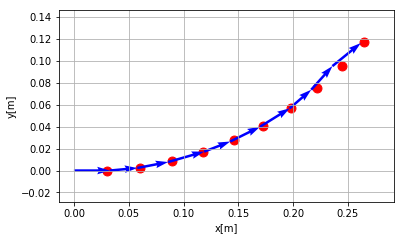

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99835576e-02 -1.26458346e-07 -1.39874211e+00]
 [ 5.97701126e-02  3.43132605e-03 -1.28404211e+00]
 [ 8.89682199e-02  1.02492625e-02 -1.16934211e+00]
 [ 1.17194167e-01  2.03640838e-02 -1.05464211e+00]
 [ 1.44077019e-01  3.36428642e-02 -9.39942109e-01]
 [ 1.69263489e-01  4.99110985e-02 -8.25242109e-01]
 [ 1.92422586e-01  6.89549947e-02 -7.10542109e-01]
 [ 2.13249959e-01  9.05242843e-02 -5.95842109e-01]
 [ 2.31471902e-01  1.14335511e-01 -4.81142109e-01]
 [ 2.46848949e-01  1.40075754e-01 -3.66442109e-01]]
 --- output --- 
[[[ 0.03191835  0.          0.11506011]
  [ 0.02720557  0.          0.12303457]
  [ 0.02881152  0.          0.11669756]
  [ 0.03337347  0.          0.11750661]
  [ 0.02484086  0.          0.11763589]
  [ 0.03013073  0.          0.12455375]
  [ 0.03120848  0.          0.15707964]
  [ 0.02758276  0.          0.1539564 ]
  [ 0.02903845  0.         -0.15707964]

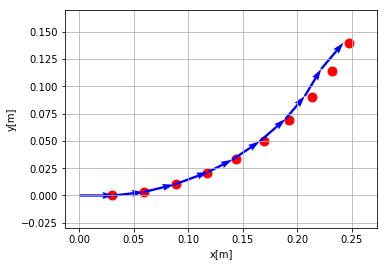

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 2.99999987e-02 -1.10904766e-07 -1.56924763e+00]
 [ 5.99999815e-02  3.06781837e-05 -1.56821763e+00]
 [ 8.99999168e-02  9.23672327e-05 -1.56718763e+00]
 [ 1.19999773e-01  1.84956177e-04 -1.56615763e+00]
 [ 1.49999517e-01  3.08444918e-04 -1.56512763e+00]
 [ 1.79999119e-01  4.62833325e-04 -1.56409763e+00]
 [ 2.09998545e-01  6.48121234e-04 -1.56306763e+00]
 [ 2.39997765e-01  8.64308448e-04 -1.56203763e+00]
 [ 2.69996746e-01  1.11139474e-03 -1.56100763e+00]
 [ 2.99995457e-01  1.38937984e-03 -1.55997763e+00]]
 --- output --- 
[[[ 0.02836022  0.          0.00035283]
  [ 0.02606163  0.          0.00631044]
  [ 0.03508586  0.          0.00017717]
  [ 0.02736875  0.         -0.00345927]
  [ 0.02931713  0.         -0.01287106]
  [ 0.03254851  0.          0.00937687]
  [ 0.03402707  0.          0.05415899]
  [ 0.02646766  0.          0.02785102]
  [ 0.03087306  0.         -0.15707964]

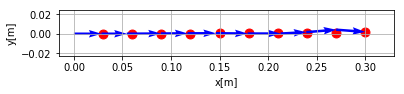

 ---------------------------------------------------------------------------------------------- 


In [14]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    
    x_test = d
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y_v,y_w = model(x)
    # clip
    v_limit = DATA_MAX_V_STEP
    w_limit = DATA_MAX_W_STEP
    v = F.clip(y_v,0.0,v_limit)
    w = F.clip(y_w,-w_limit,w_limit)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
    y_pad = F.stack((v,pad,w),axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    #print(' --- trajectory --- ')
    #print(Z)
    #print(z_true.shape)
    fig = plot_path(Z,z_true)
    fig.savefig(dirname + '/test' + str(i) + '.png')
    print(' ---------------------------------------------------------------------------------------------- ')